## Convective Timeseries

Here, I analyse a simulation where I hacked the Isca code, so it output useful tendency information.

Some diagnostics are different for this simulation. All have units of *K/s*:
* `dt_vg_diffusion`: Total temperature tendency before any diffusion calculation (basically just `dt_tg_convection` + `tdt_rad`).
* `dt_ug_diffusion`: Total temperature tendency after downward diffusion, but before upward diffusion. This is very similar to the above tendency as downward diffusion does not have much effect.
* `dt_tg_diffusion`: Total temperature tendency after all diffusion calculations. This differs near the surface to the above.
* `ucomp`: Total temperature tendency after both horizontal and vertical advection and `four_in_one` function. Basically after `spectral_dynamics`.
* `vcomp`: Total temperature tendency after the leapfrog procedure. I.e. this is `(temp(future)-temp(current))/time_step`.
* `omega`: Vertical advection temperature tendency.

In addition, I changed `delta_t_surf` so units are *K/s* rather than *K*, for ease of comparison. But still gives temperature tendency of the surface.

Here I look at how CAPE develops over time at a given coordinate.

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p
from isca_tools.utils import area_weighting, annual_mean
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.aquaplanet_theory import get_delta_temp_quant_theory, get_gamma
from isca_tools.convection.simple_betts_miller import lcl_temp, ref_temp_above_lcl, get_temp_ref
from isca_tools.convection import dry_profile_pressure, moist_profile
from isca_tools.plot import label_subplots
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import interpolate
import matplotlib.animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy_indexed
from scipy.stats import percentileofscore
import copy
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

2024-03-22 12:01:12,535 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [2]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
# save_suffix = '.pdf'          # if for paper
save_suffix = '.jpg'
dpi = {'.pdf': 800, '.jpg': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

In [73]:
var_keep = ['temp', 'sphum', 'height', 'cape', 'klzbs', 't_surf', 't_ref', 'dt_tg_convection', 'dt_tg_diffusion', 'tdt_rad', 'convflag']
exp_dir = 'play/temp_tendency/'
tau_lw_ref = 3.5
exp_names = [f"k={str(tau_lw_ref).replace('.','_')}_taubm=2000", f"k={str(tau_lw_ref).replace('.','_')}"]
# exp_names = [f"k=3_5_no_diffusion", f"k={str(tau_lw_ref).replace('.','_')}", f"k=3_5_no_diffusion_taubm=2000"]
# exp_names = [f"k=3_5_taubm=2000"]
lat_use = 5
lon_use = 0
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
conv_timescale = []

# use_time_start = 360*2
use_time_start = 360*4
use_time_end = 360*5
# use_time_start = 0      # because little data
for i in range(n_exp):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
    ds_use = ds_use.sel(lat=lat_use, lon=lon_use, method='nearest')
    ds += [ds_use.sel(time=slice(use_time_start, use_time_end)).load()]      # only keep after spin up
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
    try:
        conv_timescale += [namelist['qe_moist_convection_nml']['tau_bm']]
    except KeyError:
        conv_timescale += [7200]        # default value
# conv_timescale = ['$\kappa=3.5$ no diffusion (7200)', '$\kappa=3.5$ (7200)', '$\kappa=3.5$ no diffusion (2000)']

In [74]:
pressure_from_level_func = scipy.interpolate.interp1d(np.arange(len(ds[0].pfull)), ds[0].pfull)
def lzb(k, interp_func=pressure_from_level_func):
    # Offset by -1 because fortran starts with 1, but python starts with 0
    # ds.t_ref will match exactly ds.temp if -2 used as offset, but this is not the LNB.
    if np.size(k) == 1:
        return float(interp_func(k-1))
    else:
        return interp_func(k-1)

### Convective Details
Plot `convflag` (whether deep or shallow convection), level of neutral buoyancy and CAPE as a function of quantile for each simulation to see how convection varies with temperature.

In [75]:
rh = [ds[i].sphum.sel(pfull=np.inf, method='nearest')/sphum_sat(ds[i].temp.sel(pfull=np.inf, method='nearest'),ds[0].pfull[-1]*100) for i in range(n_exp)]

Text(0, 0.5, 'Percentage of days convecting [%]')

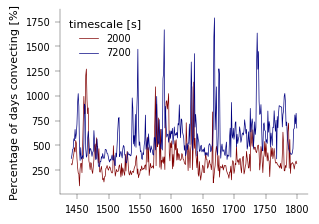

In [76]:
colors_exp = plt.cm.jet(np.linspace(0,1,n_exp))[::-1]
fig, ax = plt.subplots(1, 1, figsize=(width['one_col'], width['one_col']/ar))
for i in range(n_exp):
    ax.plot(ds[0].time, ds[i].cape, color=colors_exp[i], label=conv_timescale[i])
# ax.set_ylim(0, 100)
ax.legend(title='timescale [s]')
ax.set_ylabel('Percentage of days convecting [%]')

Text(0, 0.5, 'Percentage of days convecting [%]')

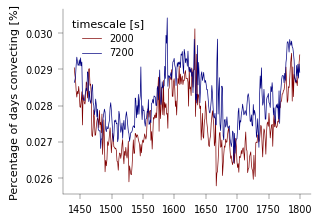

In [115]:
fig, ax = plt.subplots(1, 1, figsize=(width['one_col'], width['one_col']/ar))
for i in range(n_exp):
    ax.plot(ds[0].time, ds[i].sphum.sel(pfull=np.inf, method='nearest'), color=colors_exp[i], label=conv_timescale[i])
# ax.set_ylim(0, 100)
ax.legend(title='timescale [s]')
ax.set_ylabel('Percentage of days convecting [%]')

Text(0, 0.5, 'Percentage of days convecting [%]')

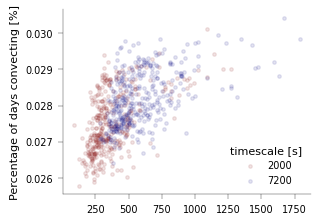

In [114]:
fig, ax = plt.subplots(1, 1, figsize=(width['one_col'], width['one_col']/ar))
for i in range(n_exp):
    ax.scatter(ds[i].cape, ds[i].sphum.sel(pfull=np.inf, method='nearest'), color=colors_exp[i], label=conv_timescale[i], alpha=0.1)
# ax.set_ylim(0, 100)
ax.legend(title='timescale [s]')
ax.set_ylabel('Percentage of days convecting [%]')

In [133]:
ds_snapshot = isca_tools.load_dataset(exp_dir + exp_names[0])[var_keep].isel(time=1621).sel(lat=slice(-20, 20)).sel(pfull=[np.inf, 500], method='nearest').load()

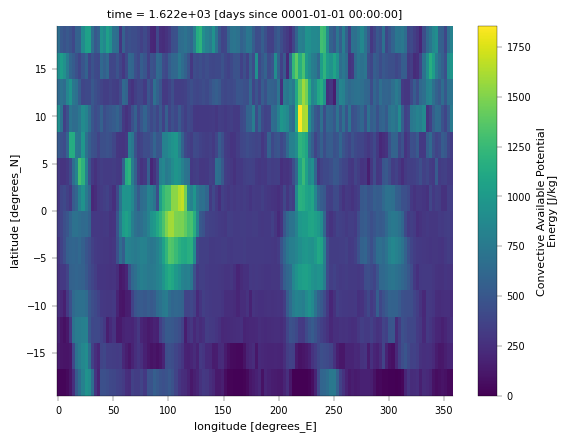

In [134]:
ds_snapshot.cape.plot()

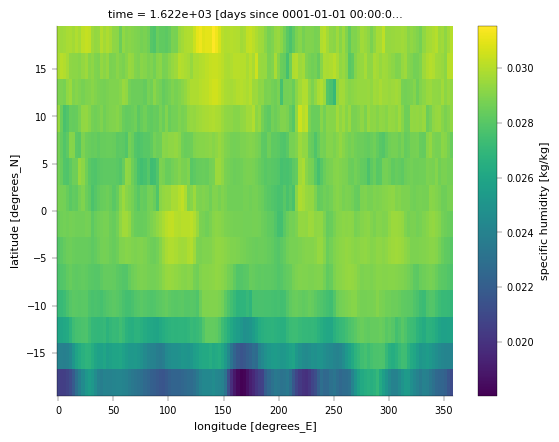

In [135]:
(ds_snapshot.sphum[0]).plot()

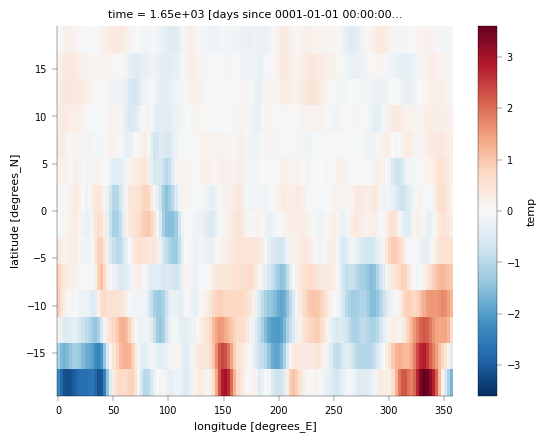

In [93]:
(ds_snapshot.temp.isel(pfull=1)-ds_snapshot.temp.isel(pfull=1).mean(dim='lon')).plot()